In [1]:
%matplotlib inline

In [2]:
cd ..

/vol/atlas/homes/gt108/Projects/ibugface


### Imports

In [3]:
import resnet_model
import tensorflow as tf
import data_provider
import menpo.io as mio
import menpo
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.platform import tf_logging as logging
from utils import (caffe_preprocess, rescale_image)
from menpo.image import Image

slim = tf.contrib.slim

### Setup TensorFlow Session

In [4]:
USE_GPU = False
CHECKPOINT_PATH = '/vol/atlas/homes/gt108/pretrained_models/keypoints/69_classes'

nogpu_config = tf.ConfigProto(
    # Do not use a GPU device
    device_count = {'GPU': int(USE_GPU)}
)

sess = tf.Session(config=nogpu_config)

In [5]:
tf_image = tf.placeholder(tf.float32, shape=(None, None, 3))

In [6]:
# Define model graph.
with tf.variable_scope('net'):
    with slim.arg_scope([slim.batch_norm, slim.layers.dropout],
                        is_training=False):
        prediction, pyramid = resnet_model.multiscale_kpts_net(tf.expand_dims(tf_image, 0), scales=(1, 2, 4))

In [7]:
variables_to_restore = slim.get_variables_to_restore()
saver = tf.train.Saver(variables_to_restore)
model_path = slim.evaluation.tf_saver.get_checkpoint_state(CHECKPOINT_PATH).model_checkpoint_path
saver.restore(sess, model_path)
print(model_path)

/vol/atlas/homes/gt108/pretrained_models/keypoints/69_classes/model.ckpt-391231


In [8]:
original_image = mio.import_images('/vol/atlas/databases/300w/', normalize=False)[0]

In [9]:
def to_colour(im):
    if im.n_channels == 1:
        im.pixels = np.vstack([im.pixels]*3)
    return im

In [10]:
def eval_image(im):
    im = rescale_image(to_colour(im))
    input_pixels = caffe_preprocess(rescale_image(im))

    estimated_kpt, image = sess.run(
        [tf.nn.softmax(prediction), tf_image],
        feed_dict={tf_image: input_pixels.transpose(1, 2, 0)})

    image = image[..., [2, 1, 0]]
    image = (image - image.min())/255.
    image = Image.init_from_channels_at_back(image.clip(0, 1))

    return estimated_kpt[0], image

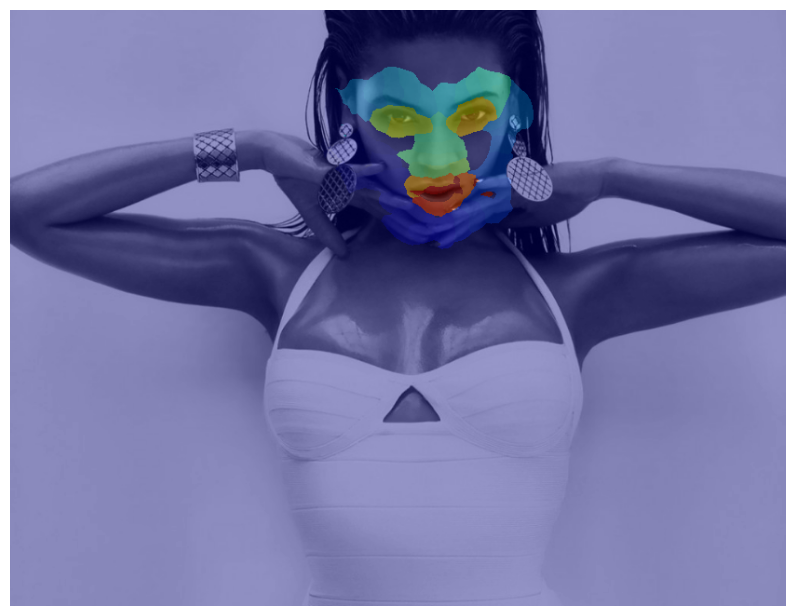

In [11]:
estimated_kpt, image = eval_image(original_image)

plt.imshow(estimated_kpt.argmax(2))
plt.axis('off');

image.as_greyscale().view(alpha=.6)